In [1]:
import config
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import random
import time
from network import *
from utility import *
from train import *
import simpy
import logging
import math
import copy

In [2]:
%matplotlib notebook
plt.ion()

In [3]:
env = simpy.Environment()

In [4]:
N = Network(config.STATIONS_FILENAME, config.RAILWAY_FILENAME , env)

In [5]:
def create_statistic_proc(env , logger , stat_time , N , trains):
    '''
    Create statistic in the log file every stat_time
    @parameters:
    env : simpy environment
    logger : log file where need to create the log
    stat_time : time after which log is to be created
    N         : network
    trains    : trains in the network
    '''
    while True :
        yield env.timeout(20)

        #create statistics
        not_yet_started = 0
        running = 0
        Completed_resource_not_freed = 0
        Completed = 0

        for t in trains:
            status = t.status()
            if (status == 'not_yet_started'):
                not_yet_started += 1
            elif (status == 'running'):
                running += 1
            elif(status == 'Completed_resource_not_freed'):
                Completed_resource_not_freed += 1
            else:
                Completed += 1
        
        if (len(trains) == Completed):
            config.TRAINS_COMPLETED_JOURNEY = True

        logger.info("Time : {} Number of trains not yet started - {}".format(env.now , not_yet_started))
        logger.info("Time : {} Number of running trains - {}".format(env.now , running))
        logger.info("Time : {} Number of trains Completed but resource not freed - {}".format(env.now , Completed_resource_not_freed))
        logger.info("Time : {} Number of trains which have Completed journey - {}".format(env.now , Completed))

In [6]:
#utility function
def update_graph (env , interval , train_to_color = None):
    '''
    This function will simulate the whole process on a GUI
    This function is going to be used as the process
    @parameters
    env : simpy environment
    total_time : total time for the simulation
    '''
    fig = plt.figure(figsize = (6 , 6))
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    
    while True:
        #Draw graph
        
        N.draw_railway_network(ax  = ax , suppress_station_info= False , 
                               suppress_track_info= False , suppress_edge_label=False , 
                               train_to_color=train_to_color)


        #yield interval time
        yield env.timeout(interval)
        time.sleep(0.5)
        
        #log info
        plt.title("Time {}".format(env.now))
        
        #Paint the canvas
        fig.canvas.draw()

In [7]:
def deadlock_detection_process (env , deadlock_time):
    '''
    For creating deadlock detection process
    '''
    global DEADLOCK
    while True:
        
        #Invoke this deadlock process after every 20 iterations
        
        yield env.timeout(deadlock_time)
        logger.info("Time : {} Checking Deadlock".format(env.now))
        config.DEADLOCK , _ = deadlock_detection(N , trains)
        


In [8]:
def compute_loss_one_train (t):
    '''
    This function should be called after the successful completion of the train
    @Parameter : Name of the train 
    @Return : Loss for the train  
    '''
    p = t.priority
    loss = 0
    
    #for each station in the path
    for route , log in zip(t.route , t.log):
        d , t1 , t2 = route
        _ , t3 , t4 = log
        
        #Compute the loss, for the arrival (may arrive before the assigned time)
        #and departure (always after the assigned time)
        if t3 >= t1:
            loss += (t3 - t1)
        if (t4 >= t2):
            loss += (t4 - t2)

    return loss / p
    

In [9]:

def compute_loss (trains):
    '''
    Takes all the trains in the network after completing the journey and then computes the value of J
    '''
    total_loss = 0
    total_departures = 0

    #for each train compute the loss, and return the total loss
    for t in trains:
        total_departures += 2*len(t.route)
        total_loss += compute_loss_one_train(t)
        
    total_loss = total_loss / total_departures
    return total_loss

In [10]:
def get_state_vector (train_name , b = 2 , l= 6 , R = 3 , w_c = 1 , w_d = 1):
    #get the train
    t = name_train_map[train_name]
    
    #find the current position 
    current = t.current_index * 2;
    if (not t.station_or_not):
        current += 1
            
    #get the local neighbors
    res =t.all_resources[ max(0 , current - b) : min(current + l+1 , len(t.all_resources )) ]
    state_vector = [0 for _ in range(len(res))]
    res_to_index = {}
    for i in range(len(res)):
        res_to_index[res[i]] = i

    #position of the train in the local space
    if (t.current == '_'):
        t1_pos = 0 
    else:
        t1_pos = res_to_index[t.current]
    

    #go through each local resource
    for t2_pos , r in enumerate(res):
        #check if the resource is station or track and get the corresponding details
        if type(r) is not str:
            s = N.get_track_details(r[0],r[1])

        else:
            s = N.get_station_details(r)
        
        towards = 0                                          #train converging towards the given train  
        away = 0                                             #trains diverging from the given train
        total = len(s.train_running)                         #total number of trains
        
        #for each train in one of the local resource 
        for running_train in s.train_running:

            if not running_train == '_':
                
                #find the next position of the train and depict wether it is moving towards or away from the resource
                t2 = name_train_map[running_train]
                index = t2.current_index * 2 
                if not (t2.station_or_not):
                    index += 1
                
                #if train is not at the last destination
                if ( index + 1 < len(t2.all_resources) ):
                    #get the next resource and find it's position
                    next_res = t2.all_resources[index + 1]
                    
                    #depending on the position, check if the train is toward or away from the current trian.
                    if next_res in res_to_index:
                        t2_next_pos = res_to_index[t2.all_resources[index + 1]]
                        if abs(t2_next_pos - t1_pos) < abs(t2_pos - t1_pos):
                            towards+=1
                        else:
                            away+=1

                    elif type(next_res) is not str and (next_res[1] , next_res[0]) in res_to_index:
                        t2_next_pos = res_to_index[(next_res[1] , next_res[0]) ]
                        if abs(t2_next_pos - t1_pos) < abs(t2_pos - t1_pos):
                            towards+=1
                        else:
                            away+=1

                    else :
                        away+=1
                else :
                    away+=1
                    
        #construct the state vector
        state_vector[t2_pos] = int(R - 1 - min (R-1 , math.floor(total - w_c * towards - w_d * away)))
    
    #make it equal to the size of the state vector
    if (current - b < 0):
        temp_list = [0] * abs(current-b)
        temp_list.extend(state_vector)
        state_vector = temp_list

    if (current + l + 1 > len(t.all_resources)):
        state_vector.extend([0] * (current + l + 1 - len(t.all_resources)) )
        
    #include the priority of the train in the state vector
    state_vector.insert(0 , t.priority)
    
    return state_vector
    

In [11]:
def state_vector_to_index (state_vector , b = 2 , l = 6 , total_priority = 3 , R = 3):
    '''
    This function takes the state vector and convert it into index used for storing purpose
    state vector is a list
    '''
    temp = 1
    ans = 0
    for i in range(1 , len(state_vector)):
        ans += temp * state_vector[i]
        temp *= R
        
    x = R ** (l + b + 1)
    return ans + (state_vector[0]-1) * x

In [12]:
def index_to_state_vector (index , b = 2 , l = 6 , R = 3 , total_priority = 3):
    '''
    Given th index , it returns the state vector
    '''
    state_vector = [0]
    x = R ** (l + b + 1)
    state_vector[0] = index//x + 1
    index = index % x
    
    while index:
        index, r = divmod(index, 3)
        state_vector.append(r)
        
    state_vector.extend( [0] * (l + b + 2 - len(state_vector)) )
    return state_vector

In [13]:
trains = read_trains(config.TRAINS_FILENAME , N , env)

In [14]:
name_train_map = {}                #Map from train name to train object; note key can be changed to train_id 
for t in trains:
    name_train_map[t.name] = t

In [15]:
#Define a map from train to color to which it belongs 
#Note this feature considers only 10 trains into account
colors = ['red' , 'saddlebrown' , 'forestgreen','dimgray' , 'darkcyan' , 'royalblue' , 'magenta' , 'darkorange' ] 
permanent_color = 'lightcoral'

train_to_color = {}
if (len(trains) <= 8):
    for i,t in enumerate(trains):
        train_to_color[t.name] = colors[i]
else:
    for i,t in enumerate(trains):
        train_to_color[t.name] = permanent_color
        
print(train_to_color)


{'Train001': 'red', 'Train002': 'saddlebrown', 'Train003': 'forestgreen', 'Train004': 'dimgray', 'Train011': 'darkcyan', 'Train012': 'royalblue', 'Train013': 'magenta', 'Train014': 'darkorange'}


In [16]:
logger = setup_logger("main_log_file" ,"Logs/log.log")

# Simulation and Algorithm

In [17]:
#hyperparameters
pho = 0.25
minimum_J = 1000000
total_priority = 3
R = 3
l = 1
b = 0
w_c = 1
w_d = 1
total_episodes = 100
w = 0.25

tau = 0.9
alpha = 0.1

EPS_START = 1.0
EPS_END = 0.1
EPS_STEPS = 300

gamma = 0.9

CURRENT_EPISODE = 0
TERMINATE = False

TOTAL_STEPS = 0

In [18]:
#Variables
total_states = total_priority * (R ** (l + b + 1))

#map for the train most recent state space
train_state_space_map = {} 
train_action_terminated = {}
reward_for_train = {}

for key , value in  name_train_map.items():
    train_state_space_map[key] = '-'
    train_action_terminated[key] = False
    reward_for_train[key] = []
#for the Q-values
Q_values = np.zeros((total_states , 2))
Q_values_100 = None

In [19]:
def epsilon_greedy (state_space , epsilon = None):
    '''
    Given the state space, pick the action according to epsilon-greedy policy.    
    '''
   #given the state space, it will select the action according to epsilon greedy policy
    actions = ['move' , 'wait']
    
    #compute epsilon
    if (epsilon is None):
        if (CURRENT_EPISODE > EPS_STEPS):
            epsilon = EPS_END
        else:
            epsilon = ((EPS_END - EPS_START) / EPS_STEPS) * CURRENT_EPISODE + EPS_START
        
    #check if the action is random or greedy
    random = np.random.choice([True , False ] , 1 , p = [epsilon , 1 - epsilon])

    #pick the action at random
    if (random):
        action = np.random.choice(actions , 1 , p = [0.5 , 0.5])
        return action[0]
    else:
        
        #pick the action greedily
        if (Q_values_100 is None):
            q_1 = Q_values[state_vector_to_index(state_space) , 0]
            q_2 = Q_values[state_vector_to_index(state_space) , 1]
        else:
            q_1 = Q_values_100[state_vector_to_index(state_space) , 0]
            q_2 = Q_values_100[state_vector_to_index(state_space) , 1]
        
        if (q_1 >= q_2):
            return 'move'
        else:
            return 'wait'

In [20]:
def get_reward (train):
    #get the status of the train
    status = train.status()
    if (status == 'not_yet_started'):
        return 0

    else:
        #if the train is on the station, take the departure time
        current_index = train.current_index

        if (train.station_or_not):
            return min(0,-(train.log[current_index][1] - train.route[current_index][1]))
        else:
            return min(0,-(train.log[current_index][2] - train.route[current_index][2]))

In [21]:
total_reward = []
INVALID_MOVES = 0
all_q_values = []

In [22]:
def choose_action_algo (env ,N ,name_train_map):
    
    '''
    This function will choose the action for the trains that need action at the
    particular simulation time
    
    This will also check if the move is valid or not.
    '''
    
    actions = ['move' , 'wait']
    
    global TERMINATE , TOTAL_STEPS , total_reward , INVALID_MOVES
    
    while True :
        #This line is extremely important
        #As this line will wait for all the events upto this current simulation point to complete first
        #and then this will execute
        for _ in range(4*len(name_train_map)):
            yield env.timeout(0)
        
        #Check if the trains need action
        if (len(config.TRAINS_NEEDING_ACTION) == 0):
            yield env.timeout(1)
        
        else:
            
            #Pick the train that needs the action most
            time ,name = pick_most_suitable_action(name_train_map , N , env)
            t = name_train_map[name]

            #construct the state vector
            state_vector = get_state_vector(name , b = b , l = l , R = R , w_c = w_c , w_d = w_d)
            action = epsilon_greedy(state_vector , epsilon = 0.1 )
            
            action_index = 0
            if action == 'wait':
                action_index = 1
                
            if action == 'move' and not (t.is_move_valid(env)):
                INVALID_MOVES += 1
                TERMINATE = True
            else:
                TERMINATE = False
            
            reward = get_reward(t)

            if not (train_state_space_map[name] == '-'):
                #computing the Q_values
                if (train_action_terminated[name] == True):
                    reward = -10000
                    
                reward_for_train[name].append((action , reward , state_vector 
                                               , Q_values[state_vector_to_index(state_vector) , 0]
                                               , Q_values[state_vector_to_index(state_vector) , 1]))
                    
                total_reward.append(reward)
                #update the Q-values
                prev_state_vector , prev_action = train_state_space_map[name]
                Q_t1 = Q_values[state_vector_to_index(prev_state_vector) , prev_action]
                Q_t2 = Q_values[state_vector_to_index(state_vector) , action_index]
                Q_t1 = Q_t1 +  alpha * ((reward + gamma * Q_t2  - Q_t1))
                Q_values[state_vector_to_index(prev_state_vector) , prev_action] = Q_t1
                
            
            train_state_space_map[name] = (state_vector , action_index)
            TOTAL_STEPS += 1
            if (TERMINATE):
                train_action_terminated[name] = True
                continue
            else:
                train_action_terminated[name] = False
                
                

            env.process(t.act_simulate(env , action))
            
            config.TRAINS_NEEDING_ACTION.remove((time,  name) )
            

In [23]:
# sim_proc = env.process(update_graph(env , 1 , train_to_color =train_to_color))
def start_episode():
    '''
    Reset everything at the start of the episode
    '''
    env = simpy.Environment()
    N.reset(env)
    for t in trains:
        t.reset(env , N)
    
        
    dead_proc = env.process(deadlock_detection_process(env , 20))
    stat_proc = env.process(create_statistic_proc(env , logger , 20 , N , trains))

    for t in trains:
        proc = env.process(t.put_train_on_track(env))

    proc_act = env.process(choose_action_algo(env , N, name_train_map))
    return env,N

In [24]:
#For plotting and storing info
J_plot = []
minimum_J_plot = []

#for logging about the total success, deadlock and completed episodes
total_deadlock = 0
completed_episodes = 0
terminated = 0

#Run for the required number of episodes
for episode in range(total_episodes):

    #reset the episode
    INVALID_MOVES = 0
    config.TRAINS_NEEDING_ACTION = []
    total_reward = []
    TOTAL_STEPS = 0
    env , N = start_episode()    
    config.DEADLOCK = True
    config.TRAINS_COMPLETED_JOURNEY = False
    config.CURRENT_SIMULATION_TIME = 0
    
    for key , value in reward_for_train.items():
        reward_for_train[key] = []
    
    TERMINATE = False
    CURRENT_EPISODE += 1

    #mark the seen to all zero for the current episode
    seen = np.zeros((total_states , 2))
    
    #This loop is not needed as such
    for time in range(0 , config.TOTAL_SIMULATION_TIME , 1):
            
        if (config.DEADLOCK== False):
            logger.warning("Time : {} Terminating Simulation. Deadlock detected".format(env.now))
#             print("Terminating Simulation : Deadlock detected")
            total_deadlock += 1 
            
            break

        if (config.TRAINS_COMPLETED_JOURNEY == True):
            logger.info("Time : {} All trains completed journey. Terminating Simulation".format(env.now))
            #print("Terminating Simulation : All trains completed journey")
            break

        config.CURRENT_SIMULATION_TIME += 1

        #Run the simulation
        env.run(until = config.CURRENT_SIMULATION_TIME)

    
    if (config.TRAINS_COMPLETED_JOURNEY):
        completed_episodes += 1
        J = compute_loss(trains)
        J_plot.append(J)
        minimum_J = min(J , minimum_J)
        minimum_J_plot.append(minimum_J)
        
    if (config.DEADLOCK == False):
        print("Episode : {} Ended in deadlock".format(episode))
    else:
        print('*' * 50)
        print ("Episode : {} , J : {:.5f} , total_time {} , total_deadlock - {}".format( episode ,J , 
                                                        config.CURRENT_SIMULATION_TIME,  total_deadlock ))

        reward_sum = np.sum(np.array(total_reward))
        temp = (reward_sum + INVALID_MOVES * 100)/(TOTAL_STEPS - INVALID_MOVES)
        print("Episode : {} Total reward {} , total_steps {}, average reward {:.2f} , invalid_moves {} , reward_step {:.2f}".format(
        episode, reward_sum , TOTAL_STEPS , reward_sum/TOTAL_STEPS, INVALID_MOVES , temp )   )
    
    
    
    all_q_values.append(copy.deepcopy(Q_values))
    
    if (episode == 900):
        Q_values_100 = copy.deepcopy(Q_values)
    

**************************************************
Episode : 0 , J : 9.37500 , total_time 41 , total_deadlock - 0
Episode : 0 Total reward -51329 , total_steps 210, average reward -244.42 , invalid_moves 5 , reward_step -247.95
**************************************************
Episode : 1 , J : 56.37500 , total_time 141 , total_deadlock - 0
Episode : 1 Total reward -177188 , total_steps 790, average reward -224.29 , invalid_moves 15 , reward_step -226.69
**************************************************
Episode : 2 , J : 62.67500 , total_time 201 , total_deadlock - 0
Episode : 2 Total reward -240926 , total_steps 1063, average reward -226.65 , invalid_moves 19 , reward_step -228.95
**************************************************
Episode : 3 , J : 13.51250 , total_time 81 , total_deadlock - 0
Episode : 3 Total reward -33119 , total_steps 328, average reward -100.97 , invalid_moves 3 , reward_step -100.98
**************************************************
Episode : 4 , J : 34.31250 

**************************************************
Episode : 36 , J : 44.83750 , total_time 181 , total_deadlock - 1
Episode : 36 Total reward -22830 , total_steps 686, average reward -33.28 , invalid_moves 0 , reward_step -33.28
**************************************************
Episode : 37 , J : 42.81250 , total_time 121 , total_deadlock - 1
Episode : 37 Total reward -20293 , total_steps 672, average reward -30.20 , invalid_moves 0 , reward_step -30.20
**************************************************
Episode : 38 , J : 23.13750 , total_time 161 , total_deadlock - 1
Episode : 38 Total reward -17156 , total_steps 485, average reward -35.37 , invalid_moves 1 , reward_step -35.24
**************************************************
Episode : 39 , J : 14.03750 , total_time 121 , total_deadlock - 1
Episode : 39 Total reward -3056 , total_steps 323, average reward -9.46 , invalid_moves 0 , reward_step -9.46
**************************************************
Episode : 40 , J : 21.70000 , to

**************************************************
Episode : 73 , J : 32.73750 , total_time 201 , total_deadlock - 1
Episode : 73 Total reward -8790 , total_steps 431, average reward -20.39 , invalid_moves 0 , reward_step -20.39
**************************************************
Episode : 74 , J : 24.08750 , total_time 101 , total_deadlock - 1
Episode : 74 Total reward -4785 , total_steps 392, average reward -12.21 , invalid_moves 0 , reward_step -12.21
**************************************************
Episode : 75 , J : 15.95000 , total_time 101 , total_deadlock - 1
Episode : 75 Total reward -2974 , total_steps 314, average reward -9.47 , invalid_moves 0 , reward_step -9.47
**************************************************
Episode : 76 , J : 18.37500 , total_time 81 , total_deadlock - 1
Episode : 76 Total reward -3629 , total_steps 344, average reward -10.55 , invalid_moves 0 , reward_step -10.55
**************************************************
Episode : 77 , J : 13.43750 , total_

In [25]:
reward_for_train

{'Train001': [('move', 0, [1, 0, 0], -1996.7734915567678, -2011.414823690081),
  ('move', 0, [1, 2, 1], -2370.8179175688147, -5547.7828050627595),
  ('wait', 0, [1, 2, 0], -2457.810282912451, -2414.8505806916314),
  ('wait', 0, [1, 2, 0], -2457.810282912451, -2414.8505806916314),
  ('wait', 0, [1, 2, 0], -2457.810282912451, -2372.8347928583644),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2349.106444929781),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2302.5592266756785),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2256.9382980648325),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2212.2252259333422),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2168.4019439372687),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2125.450745252917),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2083.354275422384),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2042.0955253414786),
  ('wait', 0, [1, 2, 0], -2371.3823726459777, -2001.6578243871832),
  ('wait', 0, [1, 2, 0], -2371.382372645977

In [26]:
for i in range(9):
    print(index_to_state_vector(i, b=b , l=l, R = R , total_priority = total_priority) , Q_values[i , :])


[1, 0, 0] [-2660.83187019 -1972.85998077]
[1, 1, 0] [-468.53297533 -563.15853121]
[1, 2, 0] [-2137.56875474 -1950.82963524]
[1, 0, 1] [-1744.0428713  -2791.81587437]
[1, 1, 1] [-1679.30652358 -2522.76361841]
[1, 2, 1] [-2511.48616195 -5157.76477736]
[1, 0, 2] [-16015.5833702   -5687.30230426]
[1, 1, 2] [-14663.78816243  -3522.73989678]
[1, 2, 2] [-10290.49018025  -2425.44564554]


In [27]:
for t in trains:
    t.print_details()

**************************************************
Train ID : 8
Name :Train001
Priority : 1
Average speed : 1
Route of the train
            Alpha : 0 - 1 
            Bravo : 2 - 3 
            Charlie : 4 - 5 
            Delta : 6 - 7 
            Echo : 8 - 9 
Train has completed the journey
______Printing log________
            Alpha : 0 1 
            Bravo : 19 25 
            Charlie : 32 59 
            Delta : 67 68 
            Echo : 83 89 
**************************************************
**************************************************
Train ID : 8
Name :Train002
Priority : 1
Average speed : 1
Route of the train
            Alpha : 0 - 1 
            Bravo : 2 - 3 
            Charlie : 4 - 5 
            Delta : 6 - 7 
            Echo : 8 - 9 
Train has completed the journey
______Printing log________
            Alpha : 0 19 
            Bravo : 50 91 
            Charlie : 107 108 
            Delta : 142 143 
            Echo : 147 176 
**************************

<IPython.core.display.Javascript object>


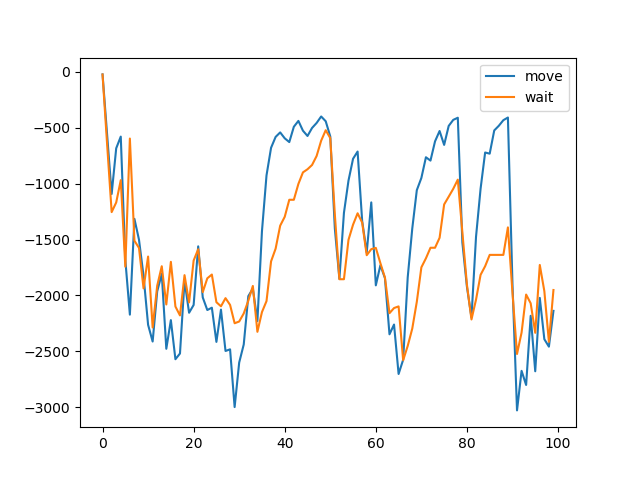

In [32]:
index= state_vector_to_index([1,2,0] , b = b, l = l , total_priority = total_priority , R = R)
temp1 = []
temp2 = []
for i in range(len(all_q_values)):
    temp1.append(all_q_values[i][index, 0])
    temp2.append(all_q_values[i][index, 1])
plt.plot(temp1 , label = 'move')
plt.plot(temp2 , label = 'wait')
plt.legend()

# Resource Usage

In [41]:
G,train_nodes , station_nodes , track_nodes = create_resource_usage_graph(trains , N)

<IPython.core.display.Javascript object>


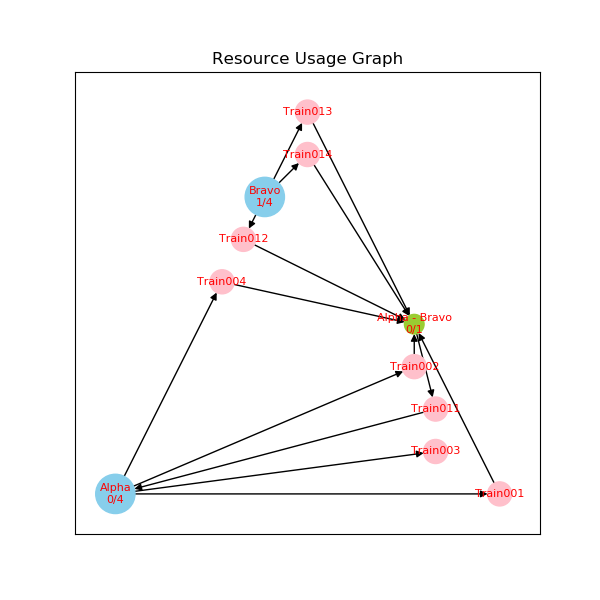

/home/arpit/anaconda3/envs/IA/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


In [42]:
fig = plt.figure(figsize = (6 , 6))
ax = fig.add_subplot(111)
draw_network_usage_graph(G,train_nodes , station_nodes , track_nodes, N,ax)

# TODO

1. Create a simple train class with all the parameters                                                Done
2. Implement the resource facility with the track and the station                                     Done
3. Run the single train on the track (without getting worried wether the resource is free or not)     Done  
4. Simulate whole thing on graph (single train only)                                                  Done
5. Run multiple instances of the train without worrying about the deadlock                            Done
   Create action for each train                                                                       Done
6. Try to simulate as you want to do in the project i.e. take action from the user.                   Done
   Also able to order the train for which to take the action at a particular time 
   
   
   
7. Try to create deadlock with the trains                                                             Done 
8. Create the graph for resource usage.                                                               Done  
9. Use the standard deadlock detection algorithm for the detection of the algorithm                   Done 
   Implement the Bank's algorithm for deadlock detection.


# List of reasons of creating events
1. If a train is standing at a station, the event processing time            Can be done by implementing timeout if train arrive early before depart time
    corresponds to the earliest time at which the train can depart,          occupancy of next track.
    as defined by its minimum halt time at the station and by any           Done
    departure time constraints enforced for passenger convenience.

2. `If it is running between two stations, the event processing time         Already done   
    corresponds to the earliest time at which it can arrive at the          occupancy of next station if move.
    next station, as defined by the length of the track and the train       Done
    running speed.

3. If the train is yet to start, the event processing                       Done
    time is the time at which it is expected at the starting station.       

# TODO

Create the actions properly and implement deadlock Avoidance heuristic

1. Code the proper list of events. All the three listed above.                                      Done
2. Create the proper time table with arrival and departure time of each train at each station.      Done
3. Create separate log file for each train.                                                         Done
3. Run simulation with the first toy environment (as in the paper).                                 Done
4. Label the current set of implementation under Simulation Phase.                                  Done
5. Implement the actions properly without actually waiting for the resource.                        Done
6. Understand Heuristic that can be used to avoid deadlock.                                         Done
7. Move that train that occupies the most congested resource first and then other.                  Done
   If tie break it using priority of each train.
   
   
8. Implement the state vector when action need to be taken.                                       Note Done



# TODO 
1. Implement the function to compute J      $\;\;\;\;\;\;\;\;\;\;\;$   Done
2. Implement the state space i.e. when taking action train should know what is the state space 
3. Implement Proxy reward.
4. Implement the Q-learning algo given in the paper
5. Check for the first test case

In [26]:
# Each wait is accumulating too much reward